In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno

import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

import seaborn as sns
import re

from scipy import stats
import statsmodels.api as sm
from collections import Counter

# import library for modeling 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split,  KFold
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score



import sklearn.metrics as metrics



#tst-train split
from sklearn.model_selection import train_test_split



import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(''):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

C:\Users\dell\AppData\Local\Temp\ipykernel_10636\2231637721.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [3]:
cwd = os.getcwd()  # your current working directory (cwd)
files = os.listdir(cwd)  # This will Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in 'c:\\info_tech_dersler\\ml_prj_airbnb\\ML_Project_Group_B': ['.git', 'catboost_info', 'Column_description.xlsx', 'data_final.csv', 'Feature_Engineering.ipynb', 'Main.ipynb', 'Missing_Values.ipynb', 'modelling.ipynb', 'Outliers.ipynb', 'README.md', 'train.csv', 'usneighborhoods.csv', 'Visualization.ipynb']


In [4]:
df = pd.read_csv('data_final.csv')


In [5]:
df.columns

Index(['log_price', 'accommodates', 'bathrooms', 'cleaning_fee',
       'host_response_rate', 'instant_bookable', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'bedrooms', 'beds',
       'log_price_new', 'property_type_Apartment', 'property_type_bed_break',
       'property_type_Bungalow', 'property_type_Condominium',
       'property_type_Dorm', 'property_type_Guesthouse', 'property_type_House',
       'property_type_Loft', 'property_type_Other', 'property_type_Townhouse',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict', 'room_type_entire_home',
       'room_type_private_room', 'room_type_shared_room', 'bed_type_Airbed',
       'bed_type_Couch', 'bed_type_Futon', 'bed_type_Pull_out_Sofa',
       'bed_type_real_Bed', 'city_Boston', 'city_Chicago', 'city_DC',
       'city_LA', 'city_NYC', 'city_SF', 'wireless_internet', 'Kitchen',
       'Heating', 'Essentials', 'smoke_detector', 'air_conditioning', 'TV',


In [6]:
df.drop('log_price' ,axis=1,inplace=True)

In [7]:
df.head()

,accommodates,bathrooms,cleaning_fee,host_response_rate,instant_bookable,number_of_reviews,review_scores_rating,thumbnail_url,bedrooms,beds,...,Iron,family_kid_friendly,fire_extinguister,first_aid_kit,cable_tv,free_parking_on_premises,alltime_check_in,lock_on_bedroom_door,"buzzer_wireless,intercom",neighbourhood_level
0,3,1.0,1,0.943841,0,2.0,100.0,1,1.0,1.0,...,1,1,0,0,0,0,0,0,0,4
1,7,1.0,1,1.000000,1,6.0,93.0,1,3.0,3.0,...,1,1,1,0,0,0,0,0,0,1
2,5,1.0,1,1.000000,1,10.0,92.0,1,1.0,3.0,...,1,1,1,0,1,0,0,0,1,4
3,4,1.0,1,0.943841,0,0.0,0.0,1,2.0,2.0,...,0,0,1,1,1,0,0,0,1,1
4,2,1.0,1,1.000000,1,4.0,40.0,0,0.0,1.0,...,0,0,1,0,0,0,0,0,0,4


In [8]:
#pd.set_option('display.max_columns', len(df.columns)) # To view all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


In [9]:


# Veri çerçevesindeki korelasyon matrisini oluşturun
correlation_matrix = df.corr()

# Target değişkeni ile diğer sütunların korelasyonunu alın
target_correlation = correlation_matrix['log_price_new'].drop('log_price_new')

# Korelasyonları veren tabloyu oluşturun
correlation_table = pd.DataFrame({'Feature': target_correlation.index, 'Correlation': target_correlation.values})

# -0.3 ile 0 arasındaki ve 0.3 ile 1 arasındaki korelasyonları filtreleyin
filtered_correlation = correlation_table[(correlation_table['Correlation'] < -0.1) & (correlation_table['Correlation'] > -1) | (correlation_table['Correlation'] > 0.1) & (correlation_table['Correlation'] < 1)]

# Tabloyu ekrana yazdırın
print(filtered_correlation)

                         Feature  Correlation
0                   accommodates     0.519225
1                      bathrooms     0.255724
2                   cleaning_fee     0.136475
7                  thumbnail_url    -0.115338
8                       bedrooms     0.409696
9                           beds     0.414853
20  cancellation_policy_flexible    -0.111260
22    cancellation_policy_strict     0.137122
23         room_type_entire_home     0.620337
24        room_type_private_room    -0.548019
25         room_type_shared_room    -0.231679
30             bed_type_real_Bed     0.108203
36                       city_SF     0.166433
38                       Kitchen     0.101930
39                       Heating     0.105705
43                            TV     0.270233
44                       Shampoo     0.109371
47                      Internet     0.103412
49                    hair_dryer     0.131115
50                        Washer     0.158085
51                         Dryer  

# eklenebilecek kodlar

import seaborn as sns
sns.pairplot(df, kind  ="reg");

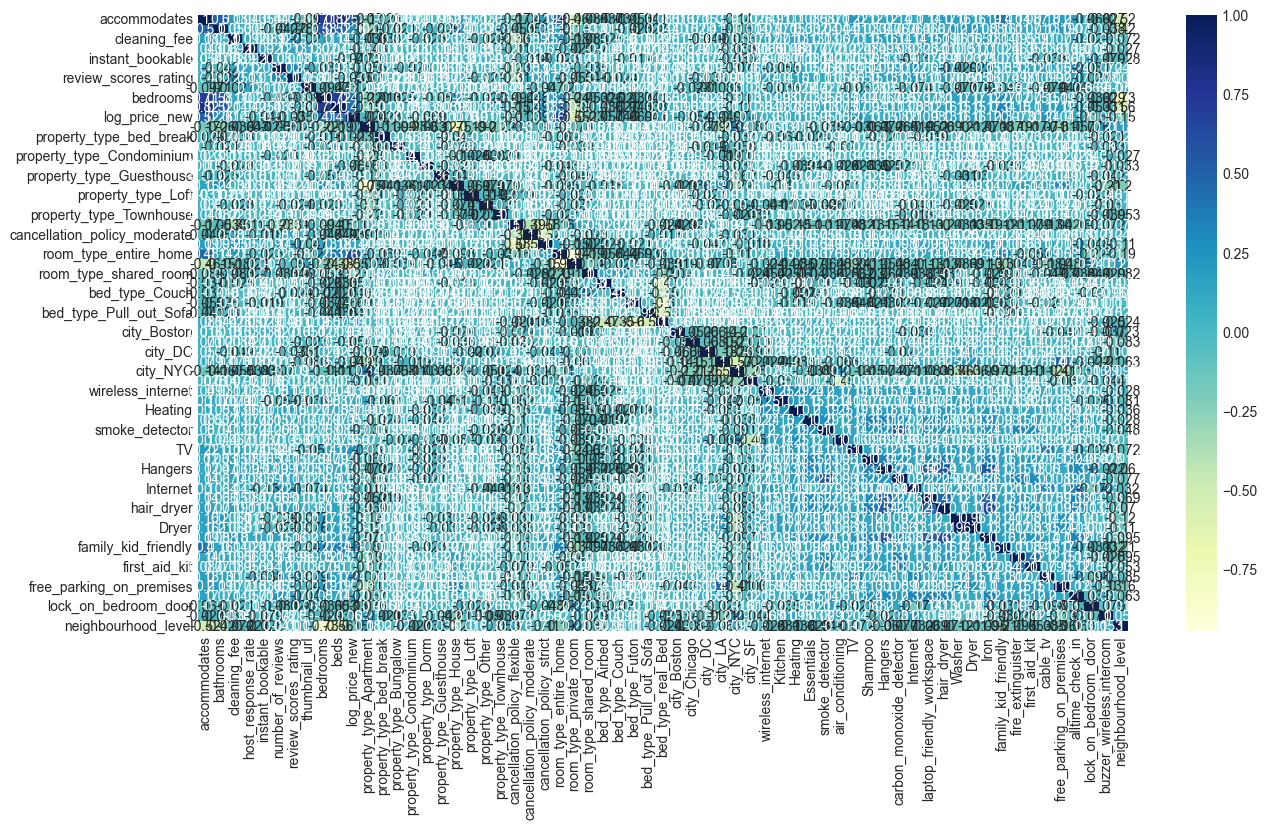

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [11]:
target_correlation = df.corr()['log_price_new'].abs().sort_values(ascending=False)
target_correlation

log_price_new                   1.000000
room_type_entire_home           0.620337
room_type_private_room          0.548019
accommodates                    0.519225
beds                            0.414853
bedrooms                        0.409696
family_kid_friendly             0.296804
TV                              0.270233
bathrooms                       0.255724
cable_tv                        0.238058
room_type_shared_room           0.231679
city_SF                         0.166433
Dryer                           0.164773
Washer                          0.158085
lock_on_bedroom_door            0.152593
neighbourhood_level             0.149521
cancellation_policy_strict      0.137122
cleaning_fee                    0.136475
hair_dryer                      0.131115
alltime_check_in                0.122798
Iron                            0.116852
thumbnail_url                   0.115338
cancellation_policy_flexible    0.111260
Shampoo                         0.109371
bed_type_real_Be

iki futura arasindaki iliski

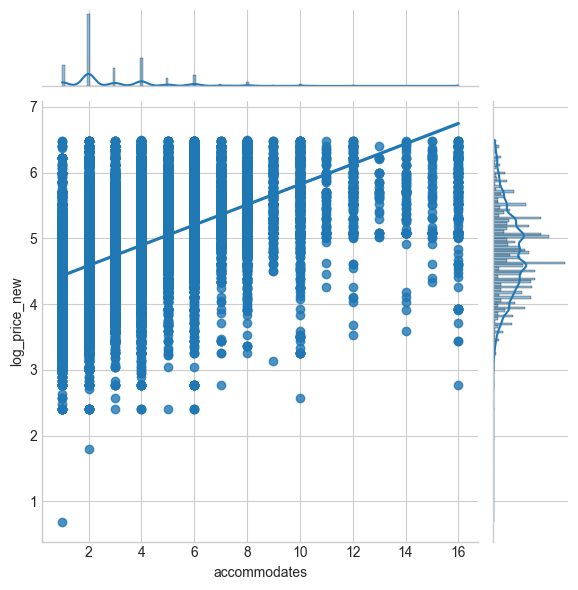

In [15]:
import seaborn as sns
sns.jointplot(x = "accommodates", y = "log_price_new", data = df, kind = "reg")

before after outlier

In [ ]:
# Create box plots for each numeric column
for column in ['CRIM', 'ZN', 'B', 'DIS' ,'MEDV']:
    plt.figure()
    plt.boxplot(df[column])
    plt.title(f"Box Plot for {column} before outliers handling")
    plt.show()
    plt.boxplot(df2[column])
    plt.title(f"Box Plot for {column} after outliers handling")
    plt.xlabel("Column")
    plt.ylabel("Values")
    plt.show()

#chack normality

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# Perform normality tests for each numeric column
for column in numeric_columns:
    data = df2[column].dropna()

    # Shapiro-Wilk test
    shapiro_stat, shapiro_pvalue = stats.shapiro(data)
    shapiro_normal = shapiro_pvalue > 0.05

    # Anderson-Darling test
    anderson_stat, anderson_crit, anderson_sign = stats.anderson(data)
    anderson_normal = anderson_stat < anderson_crit[anderson_sign == 15][0]

    # D'Agostino's K^2 test
    dagostino_stat, dagostino_pvalue = stats.normaltest(data)
    dagostino_normal = dagostino_pvalue > 0.05

    # Jarque-Bera test
    jarquebera_stat, jarquebera_pvalue = stats.jarque_bera(data)
    jarquebera_normal = jarquebera_pvalue > 0.05

    print(f"Column: {column}")
    print(f"Shapiro-Wilk test - Normal: {shapiro_normal}")
    print(f"Anderson-Darling test - Normal: {anderson_normal}")
    print(f"D'Agostino's K^2 test - Normal: {dagostino_normal}")
    print(f"Jarque-Bera test - Normal: {jarquebera_normal}")
    print()

In [ ]:
import statsmodels.api as sm
# Perform normality check using QQ plot
for column in numeric_columns:
    # Create QQ plot
    sm.qqplot(df2[column], line='s')
    plt.title(f"QQ Plot for {column}")
    plt.show()

      Model	                NDCG Score
0	LGBMClassifier	        0.8496 +/- 0.0006
0	XGBClassifier	        0.8482 +/- 0.0004
0	RandomForestClassifier	0.8451 +/- 0.0006
0	AdaBoostClassifier	    0.8429 +/- 0.0019
0	ExtraTreesClassifier	0.839 +/- 0.0008
0	LogisticRegression	    0.8378 +/- 0.001
0	DecisionTreeClassifier	0.7242 +/- 0.0023

The <b>Light GBM Classifier</b> model was chosen for hyperparameter tuning, since it's fast to train and tune, whilst being also the one with the best result without any tuning. In addition to that, it's much better for deployment, as it's much lighter than a XGBoost or Random Forest for instance, especially given the fact that we're using a free deployment cloud.</p>

https://github.com/brunodifranco/project-airbnb-classification/blob/main/airbnb.ipynb

An important task in ML modeling is Hyperparameter Tuning, on which the goal is to find the <b>best possible combination of model hyperparameters</b>. This task will be performed fitting the model to the training data, and evaluating it in the test data, which was originally split in section 5.2. But firstly the test dataset has to go through all transformations the training dataset went through:

In [ ]:
test_le = LabelEncoder()
df_test['country_destination'] = test_le.fit_transform(df_test['country_destination'])

X_test = df_test.drop('country_destination', axis=1).copy()
y_test = df_test['country_destination'].copy()

# One Hot Encoding 
X_test = pd.get_dummies(X_test, prefix=['gender'], columns=['gender'])
X_test = pd.get_dummies(X_test, prefix=['signup_method'], columns=['signup_method'])
X_test = pd.get_dummies(X_test, prefix=['signup_app'], columns=['signup_app'])
X_test = pd.get_dummies(X_test, prefix=['affiliate_channel'], columns=['affiliate_channel'])
X_test = pd.get_dummies(X_test, prefix=['first_affiliate_tracked'], columns=['first_affiliate_tracked'])
X_test = pd.get_dummies(X_test, prefix=['first_device_type'], columns=['first_device_type'])

# FrequencyEncoder
fe_language = (X_test.groupby('language').size()) / len(X_test)
X_test['language'] = X_test['language'].apply(lambda x : fe_language[x])

fe_action_type_most_common = (X_test.groupby('action_type_most_common').size()) / len(X_test)
X_test['action_type_most_common'] = X_test['action_type_most_common'].apply(lambda x : fe_action_type_most_common[x])

# RobustScaler
rs_age = RobustScaler()
rs_signup_flow = RobustScaler()
rs_secs_elapsed_median = RobustScaler()
X_test['age'] = rs_age.fit_transform(X_test[['age']].values)
X_test['signup_flow'] = rs_signup_flow.fit_transform(X_test[['signup_flow']].values)
X_test['secs_elapsed_median'] = rs_secs_elapsed_median.fit_transform(X_test[['secs_elapsed_median']].values)

# MinMaxScaler
mm_secs_elapsed_max = MinMaxScaler()
mm_secs_elapsed_mean = MinMaxScaler()
mm_secs_elapsed_sum = MinMaxScaler()
mm_secs_elapsed_std = MinMaxScaler()
mm_amount_of_sessions = MinMaxScaler()
X_test['secs_elapsed_max'] = mm_secs_elapsed_max.fit_transform(X_test[['secs_elapsed_max']].values)
X_test['secs_elapsed_mean'] = mm_secs_elapsed_mean.fit_transform(X_test[['secs_elapsed_mean']].values)
X_test['secs_elapsed_sum'] = mm_secs_elapsed_sum.fit_transform(X_test[['secs_elapsed_sum']].values)
X_test['secs_elapsed_std'] = mm_secs_elapsed_std.fit_transform(X_test[['secs_elapsed_std']].values)
X_test['amount_of_sessions'] = mm_amount_of_sessions.fit_transform(X_test[['amount_of_sessions']].values)

# StandardScaler
ss = StandardScaler()
X_test['action_type_unique'] = ss.fit_transform(X_test[['action_type_unique']].values)

# Transformation
cols = {'day_of_week_first_active': 7,   
        'month_account_created' : 12, 
        'day_first_active': 30,
        'week_of_year_account_created': 52}

for period, cycle in cols.items():
    nature_encode(X_test, period, cycle)

# final X_test
X_test = X_test[cols_selected_rf]

Out of the tested hyperparameters, Bayesian Optimization with Optuna provided the following as the best ones:

| Hyperparameter | Definition | Best Value |
|:---:|---|:---:|
| n_estimators | Number of boosting iterations | 300 |
| learning_rate | Shrinkage rate | 0.02 |
| num_leaves | max number of leaves in one tree | 45 |
| max_depth | Limit the max depth for tree model | 8 |
| min_child_samples | Minimal number of data in one leaf | 55 |
| min_child_weight | Minimal sum hessian in one leaf | 0.04 |
| subsample | Used to randomly select part of data without resampling| 0.8 |
| colsample_bytree| Used to randomly select a subset of features on each iteration| 0.85 |

In [ ]:
# Tuned Parameters
best_param =  {'n_estimators': 300,
               'learning_rate': 0.02,
               'num_leaves': 45,
               'max_depth': 8,
               'min_child_samples': 55,
               'min_child_weight': 0.04,
               'subsample': 0.8,
               'colsample_bytree': 0.85}

# Final Model
model_lgbm_final = LGBMClassifier(**best_param)

y_pred_eval, df_model_eval = model_eval(model_lgbm_final, X_train_ml, y_train_ml, X_test, y_test)
# pickle.dump(model_lgbm_final, open('model/lgbm_airbnb.pkl', 'wb'))  # Saving for deployment

df_model_eval # final model score

lgbm i secmis ve hyper parametreleri bulup tune etmis 

https://github.com/brunodifranco/project-airbnb-classification/blob/main/airbnb.ipynb

#catboost

In [ ]:
# categorical features must be str or int for catboost model

df[cat_features] = df[cat_features].astype('str')

In [ ]:
model = CatBoostRegressor(iterations=2000, 
                          learning_rate=0.05,
                          depth=10,
                          l2_leaf_reg=15,
                          loss_function='Huber:delta=1.6',
                          # save_snapshot='
                         )

model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=250,
    eval_set=(X_validation, y_validation),
    plot=True
)

# Feature importance

Look at feature importance and chose only the features that help the model

In [ ]:
portances = model.get_feature_importance()

sorted_importances = sorted(importances, reverse=True)

threshold = sorted_importances[len(sorted_importances) // 2]

selected_features = [f for i, f in enumerate(X_train.columns) if importances[i] >= threshold]

In [ ]:
# new list of categorical features in the new df
all_columns = list(X_train[selected_features].columns)
num_columns = ['accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'bathrooms', 'price']

cat_features_50 = []
for column in all_columns:
    if column not in num_columns:
        cat_features_50.append(column)

In [ ]:
# train model with top 50 features
model_2 = CatBoostRegressor(iterations=2000, 
                          learning_rate=0.08,
                          depth=10,
                          l2_leaf_reg=15,
                          loss_function='Huber:delta=1.1',
                          #save_snapshot=True
                         )

model_2.fit(
    X_train[selected_features], y_train,
    cat_features=cat_features_50,
    verbose=250,
    eval_set=(X_validation[selected_features], y_validation),
    plot=True
)


In [ ]:
## Hyperparameter Tuning
model_3 = CatBoostRegressor(loss_function='Huber:delta=1.1',
                            cat_features=cat_features_50,
                            verbose=False,
                            thread_count=-1,
                            early_stopping_rounds=5
                           )
                            

grid = {'learning_rate': [0.1, 0.13],
        'depth': [3,7,9],
        'l2_leaf_reg': [9, 13, 17],
        'iterations': [1500]
       }

randomized_search_result = model_3.randomized_search(grid,
                                                   X=X_train[selected_features],
                                                   y=y_train,
                                                   plot=True,
                                                   n_iter=5,
                                                   cv=5)


In [ ]:
best_params = randomized_search_result['params']
best_params

{'depth': 7, 'l2_leaf_reg': 9, 'iterations': 1500, 'learning_rate': 0.13}

In [ ]:
best_model = CatBoostRegressor(depth=7,
                               l2_leaf_reg=9,
                               iterations=2000,
                               learning_rate=0.13,
                               cat_features=cat_features_50,
                               thread_count=-1,
                               loss_function='Huber:delta=1.1')


best_model.fit(X=X_train[selected_features],
               y=y_train,
               plot=True,
               eval_set=(X_validation[selected_features],y_validation),
               verbose=False
               )

https://github.com/theoberva/airbnb_steamlit/blob/main/catboost_model.ipynb
catboost modeli icin link